파일을 압축해제합니다.

In [1]:
import tarfile

with tarfile.open('./korean-english-park.train.tar.gz', 'r:*') as tar_ref:
    tar_ref.extractall('./korean-english-park.train')

In [68]:
import pandas as pd
import tensorflow as tf
import matplotlib

print(pd.__version__)
print(tf.__version__)
print(matplotlib.__version__)

import re
from konlpy.tag import Mecab
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.ticker as ticker

1.3.3
2.6.0
3.4.3


파일을 불러오고 인코딩하여 DF로 만들기

In [3]:
with open('./korean-english-park.train/korean-english-park.train.ko', encoding='utf-8') as f_ko, \
     open('./korean-english-park.train/korean-english-park.train.en', encoding='utf-8') as f_en:
    ko_lines = f_ko.read().splitlines()
    en_lines = f_en.read().splitlines()

df = pd.DataFrame({'ko': ko_lines, 'en': en_lines})
df.head()
print(df['ko'][0])
print(df['en'][0])
df.info()

개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
Much of personal computing is about "can you top this?"
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94123 entries, 0 to 94122
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ko      94123 non-null  object
 1   en      94123 non-null  object
dtypes: object(2)
memory usage: 1.4+ MB


중복 제거

In [4]:
df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78968 entries, 0 to 94122
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ko      78968 non-null  object
 1   en      78968 non-null  object
dtypes: object(2)
memory usage: 1.8+ MB


preprocessing()

In [5]:
def preprocessing(sentence, s_token=False, e_token=False):
    # 가능한경우 lower 적용
    sentence = sentence.lower().strip()
    # 주요 구두점 앞뒤에 공백 삽입
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    # 괄호, 따옴표 등 특수문자 제거 (한글, 공백, 구두점만 남김)
    sentence = re.sub(r"[^가-힣0-9a-zA-Z\s.,!?]", " ", sentence)
    # 여러 공백을 하나의 공백으로
    sentence = re.sub(r"\s+", " ", sentence).strip()

    sentence = sentence.strip()

    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'
    
    return sentence

영어 결과에는 sos, eos 넣기

In [6]:
df['ko_corpus'] = df['ko'].apply(preprocessing)
df['en_corpus'] = df['en'].apply(lambda x: preprocessing(x, s_token=True, e_token=True))

print("Korean:", df['ko_corpus'][100])   # go away !
print("English:", df['en_corpus'][100])   # <start> salga de aqu ! <end>

Korean: 제 23차 연례 컴덱스 박람회의 개회사를 한 케이츠는 2년여전 기술 산업의 거품이 붕괴된 이후에 첨단 기술에 대해 부정적인 인식이 있다고 말했다 .
English: <start> gates , who opened the 23rd annual comdex trade show , said there was a negative perception of high tech following the collapse of the tech bubble about two years ago . <end>


데이터 분포 관찰

ko 문장의 최단 길이: 0
ko 문장의 최장 길이: 330
ko 문장의 평균 길이: 64


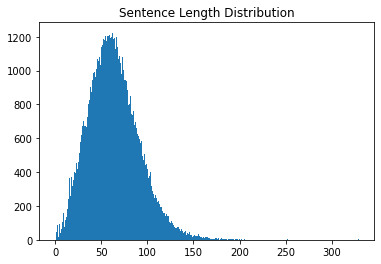

In [7]:
min_len = 999
max_len = 0
sum_len = 0

for sen in df['ko_corpus']:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("ko 문장의 최단 길이:", min_len)
print("ko 문장의 최장 길이:", max_len)
print("ko 문장의 평균 길이:", sum_len // len(df['ko_corpus']))

sentence_length = np.zeros((max_len), dtype=int)

for sen in df['ko_corpus']:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [8]:
empty_rows = df[df['ko_corpus'].str.len() == 0]

print(f"총 {len(empty_rows)}개의 빈 ko_corpus가 있습니다.")
print(empty_rows[['ko', 'ko_corpus', 'en', 'en_corpus']])

총 1개의 빈 ko_corpus가 있습니다.
      ko ko_corpus en       en_corpus
11724  ’            "  <start>  <end>


전처리 이후 길이가 0인 문장이 있어, 살펴보니 ' 하나로 구성된 텍스트.

필요 없다고 판단되어 제거했습니다.

In [9]:
df = df[df['ko_corpus'].str.len() > 0].reset_index(drop=True)

en 문장의 최단 길이: 14
en 문장의 최장 길이: 624
en 문장의 평균 길이: 149


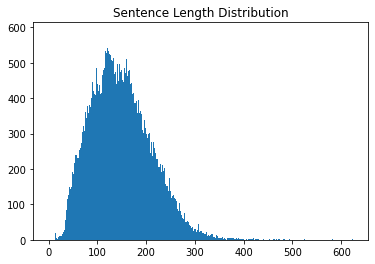

In [10]:
min_len = 999
max_len = 0
sum_len = 0

for sen in df['en_corpus']:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("en 문장의 최단 길이:", min_len)
print("en 문장의 최장 길이:", max_len)
print("en 문장의 평균 길이:", sum_len // len(df['en_corpus']))

sentence_length = np.zeros((max_len), dtype=int)

for sen in df['en_corpus']:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

### 토큰화

한국어는 Mecab, 영어는 keras 내장 Tokenizer를 사용했습니다.

\<start>, \<end> 토큰을 포함하여 40개 이하의 토큰으로 구성되도록,

VOCAB_SIZE는 최대한 많은 vocab을 가지면서 OOM문제를 발생하지 않는 15000으로 설정하였습니다.


In [11]:
MAX_LEN = 40
VOCAB_SIZE = 15000

tokenizer_ko = Mecab()
df['ko_morphs'] = df['ko_corpus'].apply(tokenizer_ko.morphs)

모든 문장의 형태소의 수를 세어, 가장 많이 등장한 순으로 VOCAB_SIZE만큼만 사용.

토큰 수가 40개 이하인 것만 사용.

In [12]:
from collections import Counter
from itertools import chain

OOV_TOKEN = '<unk>'
# 모든 문장의 형태소를 한 줄의 list로 반환
all_tokens = list(chain.from_iterable(df['ko_morphs']))

token_counts = Counter(all_tokens)
top_tokens = [token for token, _ in token_counts.most_common(VOCAB_SIZE-1)]
vocab = {OOV_TOKEN: 1}
for idx, token in enumerate(top_tokens, start=2):
    vocab[token] = idx

# 정수 시퀀스 + 길이 제한
def encode_and_filter(tokens):
    ids = [vocab.get(token, vocab[OOV_TOKEN]) for token in tokens]
    return ids if len(ids) <= MAX_LEN else None

df['ko_token'] = df['ko_morphs'].apply(encode_and_filter)
df = df[df['ko_token'].notnull()].reset_index(drop=True)

In [13]:
df['ko_token'] = pad_sequences(df['ko_token'], padding='post', maxlen=MAX_LEN).tolist()

In [14]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

def tokenize(corpus, max_len=40, num_words=VOCAB_SIZE):
    tokenizer = Tokenizer(num_words=num_words, filters='', oov_token='<unk>')
    tokenizer.fit_on_texts(corpus)

    sequences = tokenizer.texts_to_sequences(corpus)

    # max_len 이하 문장만 필터링
    filtered = [(seq, sent) for seq, sent in zip(sequences, corpus) if len(seq) <= max_len]

    filtered_seqs = [seq for seq, _ in filtered]
    filtered_corpus = [sent for _, sent in filtered]

    tensor = pad_sequences(filtered_seqs, padding='post', maxlen=max_len)

    return tensor, tokenizer, filtered_corpus

영어 데이터는 keras기반 tokenizer로 40개 토큰 이하만 선정.

In [15]:
en_tensor, tokenizer_en, filtered_en_corpus = tokenize(df['en_corpus'], max_len=MAX_LEN)

df = df[df['en_corpus'].isin(filtered_en_corpus)].reset_index(drop=True)

df['en_token'] = en_tensor.tolist()

In [16]:
df.head()

,ko,en,ko_corpus,en_corpus,ko_morphs,ko_token,en_token
0,"개인용 컴퓨터 사용의 상당 부분은 ""이것보다 뛰어날 수 있느냐?""","Much of personal computing is about ""can you t...",개인용 컴퓨터 사용의 상당 부분은 이것보다 뛰어날 수 있느냐 ?,<start> much of personal computing is about ca...,"[개인, 용, 컴퓨터, 사용, 의, 상당, 부분, 은, 이것, 보다, 뛰어날, 수,...","[708, 649, 563, 175, 7, 1415, 905, 9, 767, 161...","[4, 289, 8, 1369, 8746, 17, 45, 102, 88, 206, ..."
1,모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하...,so a mention a few weeks ago about a rechargea...,모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하...,<start> so a mention a few weeks ago about a r...,"[모든, 광, 마우스, 와, 마찬가지, 로, 이, 광, 마우스, 도, 책상, 위, ...","[212, 5273, 7084, 29, 2751, 22, 4, 5273, 7084,...","[4, 143, 9, 3744, 9, 401, 400, 276, 45, 9, 144..."
2,그러나 이것은 또한 책상도 필요로 하지 않는다.,"Like all optical mice, But it also doesn't nee...",그러나 이것은 또한 책상도 필요로 하지 않는다 .,"<start> like all optical mice , but it also do...","[그러나, 이것, 은, 또한, 책상, 도, 필요, 로, 하, 지, 않, 는다, .]","[92, 767, 9, 185, 7321, 37, 238, 22, 11, 28, 4...","[4, 161, 76, 12843, 5024, 6, 33, 20, 55, 984, ..."
3,"""결정적인 순간에 그들의 능력을 증가시켜 줄 그 무엇이 매우 중요합니다.""","""Something that will boost their capabilities ...",결정적인 순간에 그들의 능력을 증가시켜 줄 그 무엇이 매우 중요합니다 .,<start> something that will boost their capabi...,"[결정, 적, 인, 순간, 에, 그, 들, 의, 능력, 을, 증가, 시켜, 줄, 그...","[210, 32, 25, 1440, 8, 27, 15, 7, 1416, 6, 338...","[4, 812, 16, 34, 1972, 46, 7438, 21, 1973, 368..."
4,연구가들이 이미 커피 대체품으로서 음식 대용 과자나 껌에 카페인을 첨가하는 방법을 ...,Researchers are already exploring ways to put ...,연구가들이 이미 커피 대체품으로서 음식 대용 과자나 껌에 카페인을 첨가하는 방법을 ...,<start> researchers are already exploring ways...,"[연구가, 들, 이, 이미, 커피, 대체, 품, 으로서, 음식, 대용, 과자, 나,...","[1, 15, 4, 387, 2752, 2158, 2960, 1239, 1344, ...","[4, 1200, 31, 345, 7790, 1675, 7, 390, 8747, 1..."


In [17]:
print("Vocab 크기:", len(vocab))

for token, idx in list(vocab.items())[:10]:
    print(f"{token} → {idx}")

Vocab 크기: 15000
<unk> → 1
. → 2
다 → 3
이 → 4
는 → 5
을 → 6
의 → 7
에 → 8
은 → 9
를 → 10


In [18]:
print("제한된 단어 수:", tokenizer_en.num_words)
print("전체 단어 수:", len(tokenizer_en.word_index))

제한된 단어 수: 15000
전체 단어 수: 41012


In [19]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

드롭아웃 0.3을 적용한 lstm기반 seq2seq + attention 모델

In [20]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, dropout_rate=0.3):
        super(Encoder, self).__init__()
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.lstm = tf.keras.layers.LSTM(
            enc_units,
            return_state=True,
            return_sequences=True,
            dropout=dropout_rate,           # LSTM 내부 dropout
        )

    def call(self, x):
        out = self.embedding(x)
        out = self.dropout(out)
        out, h, c = self.lstm(out)
        return out, h, c


class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, dropout_rate=0.3):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.lstm = tf.keras.layers.LSTM(
            dec_units,
            return_sequences=True,
            return_state=True,
            dropout=dropout_rate,
        )
        self.fc = tf.keras.layers.Dense(vocab_size)
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, c_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        x = self.embedding(x)
        x = self.dropout(x)

        x = tf.concat([tf.expand_dims(context_vec, 1), x], axis=-1)
        out, h_dec, c_dec = self.lstm(x, initial_state=[h_dec, c_dec])
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, c_dec, attn

In [21]:
BATCH_SIZE     = 32
SRC_VOCAB_SIZE = VOCAB_SIZE
TGT_VOCAB_SIZE = VOCAB_SIZE

units         = 1024
embedding_dim = 512

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 30

sample_enc = tf.random.uniform(
    (BATCH_SIZE, sequence_len),
    minval=0,
    maxval=VOCAB_SIZE,
    dtype=tf.int32
)
enc_out, h_enc, c_enc = encoder(sample_enc)

sample_logits, h_dec, c_dec, attn = decoder(
    tf.random.uniform((BATCH_SIZE, 1), minval=0, maxval=VOCAB_SIZE,dtype=tf.int32),
    h_enc,
    c_enc,
    enc_out
)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Decoder Output: (32, 15000)
Decoder Hidden State: (32, 1024)
Attention: (32, 30, 1)


In [22]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)


In [83]:
#@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        # 컨텍스트 벡터 생성
        enc_out, h_dec, c_dec = encoder(src)

        
        # 디코더에 입력으로 넣을 <start> token 생성
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        _ = decoder(dec_src, h_dec, c_dec, enc_out)

        for t in range(1, tgt.shape[1]):
            # dec_src 다음으로 올 단어를 예측
            pred, h_dec, c_dec, _ = decoder(dec_src, h_dec, c_dec, enc_out)

            # 예측과 실제 값을 비교하여 loss계산
            loss += loss_function(tgt[:, t], pred)
            # dec_src는 예측단어가 아닌 실제 단어 사용.
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

In [24]:
from tqdm import tqdm    # tqdm
import random
from sklearn.model_selection import train_test_split

enc_token = df['ko_token'].tolist()
dec_token = df['en_token'].tolist()

enc_train, enc_val, dec_train, dec_val = train_test_split(enc_token, dec_token, test_size=0.1, random_state=42)

enc_train = tf.convert_to_tensor(enc_train, dtype=tf.int32)
enc_val   = tf.convert_to_tensor(enc_val, dtype=tf.int32)
dec_train = tf.convert_to_tensor(dec_train, dtype=tf.int32)
dec_val   = tf.convert_to_tensor(dec_val, dtype=tf.int32)


train_dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train))
train_dataset = train_dataset.shuffle(buffer_size=len(enc_train)).batch(BATCH_SIZE, drop_remainder=True)

val_dataset = tf.data.Dataset.from_tensor_slices((enc_val, dec_val))
val_dataset = val_dataset.batch(BATCH_SIZE)

EPOCHS = 20

patience = 3
best_val_loss = float('inf')
patience_counter = 0

train_losses = []
val_losses = []

# 4. 학습 루프
for epoch in range(EPOCHS):
    total_loss = 0
    val_loss = 0

    t = tqdm(train_dataset, desc=f"[Epoch {epoch+1}]")

    # 학습 루프
    for (enc_batch, dec_batch) in t:
        batch_loss = train_step(enc_batch, dec_batch, encoder, decoder, optimizer, tokenizer_en)
        total_loss += batch_loss
        t.set_postfix(loss=total_loss.numpy() / (t.n + 1))

    train_loss = total_loss.numpy() / len(train_dataset)
    train_losses.append(train_loss)

    # 검증 루프
    for (enc_batch, dec_batch) in val_dataset:
        val_batch_loss = train_step(enc_batch, dec_batch, encoder, decoder, optimizer, tokenizer_en)
        val_loss += val_batch_loss

    val_loss = val_loss.numpy() / len(val_dataset)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Early Stopping 조건
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered!")
            break

[Epoch 1]: 100%|██████████| 1718/1718 [10:43<00:00,  2.67it/s, loss=3.3] 


Epoch 1, Train Loss: 3.3026, Val Loss: 2.8977


[Epoch 2]: 100%|██████████| 1718/1718 [10:00<00:00,  2.86it/s, loss=2.66]


Epoch 2, Train Loss: 2.6554, Val Loss: 2.4481


[Epoch 3]: 100%|██████████| 1718/1718 [10:00<00:00,  2.86it/s, loss=2.29]


Epoch 3, Train Loss: 2.2889, Val Loss: 2.1195


[Epoch 4]: 100%|██████████| 1718/1718 [10:00<00:00,  2.86it/s, loss=1.99]


Epoch 4, Train Loss: 1.9923, Val Loss: 1.8259


[Epoch 5]: 100%|██████████| 1718/1718 [09:59<00:00,  2.86it/s, loss=1.72]


Epoch 5, Train Loss: 1.7235, Val Loss: 1.5674


[Epoch 6]:  13%|█▎        | 225/1718 [01:18<08:43,  2.85it/s, loss=1.41]


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

# 데이터 정의
epochs = [1, 2, 3, 4, 5]
train_losses = [3.3026, 2.6554, 2.2889, 1.9923, 1.7235]
val_losses = [2.8977, 2.4481, 2.1195, 1.8259, 1.5674]

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, marker='o', label='Train Loss')
plt.plot(epochs, val_losses, marker='s', label='Validation Loss')
plt.title('Training vs Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.xticks(epochs)
plt.tight_layout()
plt.show()

![](images/output.png)

In [69]:
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((dec_train.shape[-1], enc_train.shape[-1]))
    
    sentence = preprocessing(sentence, s_token=True)
    tokens = tokenizer_ko.morphs(sentence)
    
    inputs = [vocab.get(token, vocab['<unk>']) for token in tokens]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)
    
    result = ''

    enc_out, dec_hidden, dec_cell = encoder(inputs)

    #dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([tokenizer_en.word_index['<start>']], 0)

    for t in range(dec_train.shape[-1]):
        predictions, dec_hidden, dec_cell, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             dec_cell,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += tokenizer_en.index_word[predicted_id] + ' '

        if tokenizer_en.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention


In [72]:
import matplotlib as mpl

#  한글 폰트 설정 (나눔고딕 or 사용자 정의 경로)
mpl.rcParams['font.family'] = 'NanumGothic'  # 또는 'AppleGothic', 'Malgun Gothic'

# 마이너스 깨짐 방지
mpl.rcParams['axes.unicode_minus'] = False

In [73]:
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence.split())]
    plot_attention(attention, sentence.split(), result.split(' '))

Input: <start> 오바마는 대통령이다 .
Predicted translation: the obamas are now <unk> by president elect barack obama . <end> 


/tmp/ipykernel_60/2670106283.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_60/2670106283.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


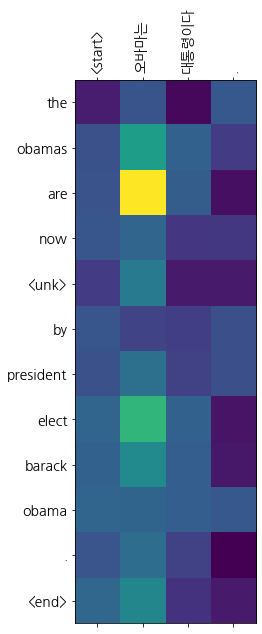

Input: <start> 시민들은 도시 속에 산다 .
Predicted translation: <unk> <unk> of the <unk> <unk> <unk> in the city . <end> 


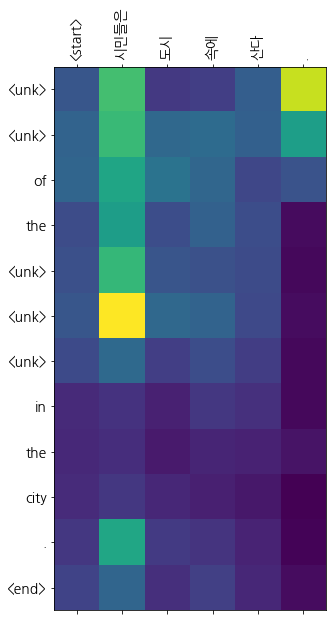

Input: <start> 커피는 필요 없다 .
Predicted translation: the <unk> of <unk> , which has not been a <unk> . <end> 


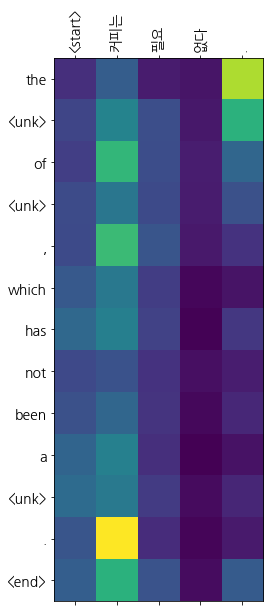

Input: <start> 일곱 명의 사망자가 발생했다 .
Predicted translation: ten of the dead included <unk> , a <unk> of the <unk> <unk> , has died . <end> 


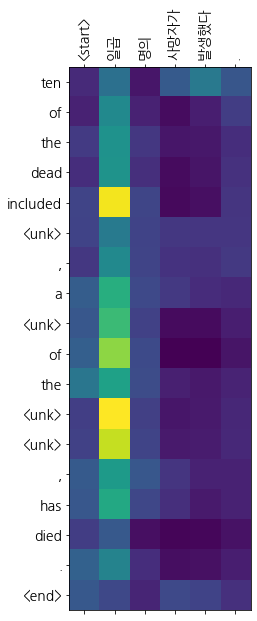

In [74]:
conv_list = ["오바마는 대통령이다.","시민들은 도시 속에 산다.","커피는 필요 없다.","일곱 명의 사망자가 발생했다."]

for conv in conv_list:
    translate(conv, encoder, decoder)

### 결과 분석

- Input: \<start> 오바마는 대통령이다 .

- Predicted translation: the obamas are now \<unk> by president elect barack obama . \<end> 

비교적 적은 unk 토큰이 있는 샘플. 오바마와 obamas, president, barack에 높은 어텐션이 기록됨.

오바마와 관련된 영단어가 잘 연결된 모습.


- Input: \<start> 일곱 명의 사망자가 발생했다 .

- Predicted translation: ten of the dead included \<unk> , a \<unk> of the \<unk> \<unk> , has died . \<end> 

일곱 대신 ten을 생성하였지만, 사망에 관련된 영단어는 잘 생성한 샘플.

unk가 많이 발생하고, 모델이 included, unk 등 비교적 불필요한 단어에 집중하는 모습을 보임.



In [92]:
def all_codes(VOCAB_SIZE=30000, BATCH_SIZE=32, units = 512, embedding_dim = 256):
    with open('./korean-english-park.train/korean-english-park.train.ko', encoding='utf-8') as f_ko, \
         open('./korean-english-park.train/korean-english-park.train.en', encoding='utf-8') as f_en:
            ko_lines = f_ko.read().splitlines()
            en_lines = f_en.read().splitlines()

    df = pd.DataFrame({'ko': ko_lines, 'en': en_lines})
    df = df.drop_duplicates()
    
    df['ko_corpus'] = df['ko'].apply(preprocessing)
    df['en_corpus'] = df['en'].apply(lambda x: preprocessing(x, s_token=True, e_token=True))
    df = df[df['ko_corpus'].str.len() > 0].reset_index(drop=True)
    
    tokenizer_ko = Mecab()
    df['ko_morphs'] = df['ko_corpus'].apply(tokenizer_ko.morphs)
    
    OOV_TOKEN = '<unk>'
    # 모든 문장의 형태소를 한 줄의 list로 반환
    all_tokens = list(chain.from_iterable(df['ko_morphs']))

    token_counts = Counter(all_tokens)
    top_tokens = [token for token, _ in token_counts.most_common(VOCAB_SIZE-1)]
    vocab = {OOV_TOKEN: 1}
    for idx, token in enumerate(top_tokens, start=2):
        vocab[token] = idx

    # 정수 시퀀스 + 길이 제한
    df['ko_token'] = df['ko_morphs'].apply(encode_and_filter)
    df = df[df['ko_token'].notnull()].reset_index(drop=True)
    df['ko_token'] = pad_sequences(df['ko_token'], padding='post', maxlen=MAX_LEN).tolist()
    
    en_tensor, tokenizer_en, filtered_en_corpus = tokenize(df['en_corpus'], max_len=MAX_LEN)
    df = df[df['en_corpus'].isin(filtered_en_corpus)].reset_index(drop=True)
    df['en_token'] = en_tensor.tolist()
    
    SRC_VOCAB_SIZE = VOCAB_SIZE
    TGT_VOCAB_SIZE = VOCAB_SIZE

    encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
    decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)
    
    optimizer = tf.keras.optimizers.Adam()
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    
    enc_token = df['ko_token'].tolist()
    dec_token = df['en_token'].tolist()

    enc_train, enc_val, dec_train, dec_val = train_test_split(enc_token, dec_token, test_size=0.1, random_state=42)

    enc_train = tf.convert_to_tensor(enc_train, dtype=tf.int32)
    enc_val   = tf.convert_to_tensor(enc_val, dtype=tf.int32)
    dec_train = tf.convert_to_tensor(dec_train, dtype=tf.int32)
    dec_val   = tf.convert_to_tensor(dec_val, dtype=tf.int32)

    train_dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train))
    train_dataset = train_dataset.shuffle(buffer_size=len(enc_train)).batch(BATCH_SIZE, drop_remainder=True)

    val_dataset = tf.data.Dataset.from_tensor_slices((enc_val, dec_val))
    val_dataset = val_dataset.batch(BATCH_SIZE)

    EPOCHS = 20

    patience = 3
    best_val_loss = float('inf')
    patience_counter = 0

    train_losses = []
    val_losses = []

    # 4. 학습 루프
    for epoch in range(EPOCHS):
        total_loss = 0
        val_loss = 0

        t = tqdm(train_dataset, desc=f"[Epoch {epoch+1}]")

        # 학습 루프
        for (enc_batch, dec_batch) in t:
            batch_loss = train_step(enc_batch, dec_batch, encoder, decoder, optimizer, tokenizer_en)
            total_loss += batch_loss
            t.set_postfix(loss=total_loss.numpy() / (t.n + 1))

        train_loss = total_loss.numpy() / len(train_dataset)
        train_losses.append(train_loss)

        # 검증 루프
        for (enc_batch, dec_batch) in val_dataset:
            val_batch_loss = train_step(enc_batch, dec_batch, encoder, decoder, optimizer, tokenizer_en)
            val_loss += val_batch_loss

        val_loss = val_loss.numpy() / len(val_dataset)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Early Stopping 조건
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered!")
                break
                
    conv_list = ["오바마는 대통령이다.","시민들은 도시 속에 산다.","커피는 필요 없다.","일곱 명의 사망자가 발생했다."]

    for conv in conv_list:
        translate(conv, encoder, decoder)
    
    return encoder, decoder

세션 에러로 인한 추가실험

In [ ]:
myencoder, mydecoder = all_codes(VOCAB_SIZE=30000, BATCH_SIZE=64, units = 1024, embedding_dim = 256)

[Epoch 1]: 100%|██████████| 859/859 [12:23<00:00,  1.16it/s, loss=3.69]


Epoch 1, Train Loss: 3.6878, Val Loss: 3.3607


[Epoch 2]: 100%|██████████| 859/859 [12:03<00:00,  1.19it/s, loss=3.2] 


Epoch 2, Train Loss: 3.2048, Val Loss: 3.0893


[Epoch 3]: 100%|██████████| 859/859 [11:59<00:00,  1.19it/s, loss=2.98]


Epoch 3, Train Loss: 2.9822, Val Loss: 2.8872


[Epoch 4]: 100%|██████████| 859/859 [12:04<00:00,  1.19it/s, loss=2.8] 


Epoch 4, Train Loss: 2.7977, Val Loss: 2.7081


[Epoch 5]: 100%|██████████| 859/859 [12:04<00:00,  1.19it/s, loss=2.63]


Epoch 5, Train Loss: 2.6272, Val Loss: 2.5409


[Epoch 6]: 100%|██████████| 859/859 [12:12<00:00,  1.17it/s, loss=2.47]


Epoch 6, Train Loss: 2.4708, Val Loss: 2.3940


[Epoch 7]: 100%|██████████| 859/859 [12:10<00:00,  1.18it/s, loss=2.33]


Epoch 7, Train Loss: 2.3348, Val Loss: 2.2686


[Epoch 8]: 100%|██████████| 859/859 [12:11<00:00,  1.17it/s, loss=2.21]


Epoch 8, Train Loss: 2.2094, Val Loss: 2.1511


[Epoch 9]: 100%|██████████| 859/859 [12:12<00:00,  1.17it/s, loss=2.09]


Epoch 9, Train Loss: 2.0896, Val Loss: 2.0462


[Epoch 10]: 100%|██████████| 859/859 [12:14<00:00,  1.17it/s, loss=1.97]


Epoch 10, Train Loss: 1.9716, Val Loss: 1.9336


[Epoch 11]: 100%|██████████| 859/859 [12:18<00:00,  1.16it/s, loss=1.86]


Epoch 11, Train Loss: 1.8554, Val Loss: 1.8161


[Epoch 12]: 100%|██████████| 859/859 [12:11<00:00,  1.17it/s, loss=1.74]


Epoch 12, Train Loss: 1.7411, Val Loss: 1.7075


[Epoch 13]: 100%|██████████| 859/859 [12:12<00:00,  1.17it/s, loss=1.63]


Epoch 13, Train Loss: 1.6302, Val Loss: 1.6112


[Epoch 14]: 100%|██████████| 859/859 [12:12<00:00,  1.17it/s, loss=1.52]


Epoch 14, Train Loss: 1.5226, Val Loss: 1.5286


[Epoch 15]:  46%|████▋     | 399/859 [05:41<06:34,  1.16it/s, loss=1.4] 

![](images/error.png)

all code로 하나의 함수로 묶어서 실행해봤는데,

학습 결과 모델이 sos 토큰에 과도한 집중을 보여주는 모습을 보였다.

코드 디버깅 결과, vocab을 업데이트 하는 부분이 누락되어 있음을 확인함.

### 회고

unk가 생각보다 많이 발생해서 vocab size를 늘려서 추가실험을 실행해보고자 했는데,

실험 결과를 확인하지 못해서 아쉬움이 있다.

어텐션 맵을 통해 모델이 어떤 단어에 집중하는지를 확인할 수 있어서

디버깅 용도로 활용할 수 있었음을 새롭게 배울 수 있었다.